# LSTM 实战

`LSTM` (Long Short Term Memory) 是一种 RNN 特殊的类型，可以学习长期依赖信息。LSTM 由Hochreiter & Schmidhuber (1997)提出，并在近期被Alex Graves进行了改良和推广。在很多问题，LSTM 都取得相当巨大的成功，并得到了广泛的使用。

LSTM 通过刻意的设计来避免长期依赖问题。记住长期的信息在实践中是 LSTM 的默认行为，而非需要付出很大代价才能获得的能力！

所有 RNN 都具有一种重复神经网络模块的链式的形式。在标准的 RNN 中，这个重复的模块只有一个非常简单的结构
![](../data/images/RNN-structure.png)

LSTM 同样是这样的结构，但是重复的模块拥有一个不同的结构。不同于 单一神经网络层，这里是有四个，以一种非常特殊的方式进行交互。
![](../data/images/LSTM-structure.png)


在我们 LSTM 中的第一步是决定我们会从细胞状态中丢弃什么信息。这个决定通过一个称为忘记门层完成。该门会读取 *h_{t-1}* 和 *x_t*，输出一个在 0 到 1 之间的数值给每个在细胞状态 *Y_{t-1}* 中的数字。1 表示“完全保留”，0 表示“完全舍弃”。

让我们回到语言模型的例子中来基于已经看到的预测下一个词。在这个问题中，细胞状态可能包含当前主语的性别，因此正确的代词可以被选择出来。当我们看到新的主语，我们希望忘记旧的主语。
![](../data/images/RNN_Gif.gif)

然后引入记忆概念。把上一个时间步产生的结果（ *Y_{t-1}* ）同X一起输入进去
![](../data/images/LSTM-Gif.gif)


更多关于 *RNN and LSTM* 的介绍请移步
- [LSTM神经网络输入输出究竟是怎样的](https://www.zhihu.com/question/41949741)
- [推荐给初学LSTM或者懂个大概却不完全懂的人](https://blog.csdn.net/roslei/article/details/61912618)
- [理解 LSTM 网络](https://www.jianshu.com/p/9dc9f41f0b29)
- [零基础入门深度学习(5) - 循环神经网络](https://www.zybuluo.com/hanbingtao/note/541458)

# 【本文知识点】
- LSTM 网络
- Pandas
- Numpy
- 用LSTM网络来预测机场客流量

# 【目录】
- [1.数据准备](#1.数据准备)
- [2.数据预处理](#2.数据预处理)
- [3.创建LSTM网络模型](#3.创建LSTM网络模型)
- [4.总结](#总结)

# 1.数据准备

数据在 `data`目录下的"international-airline-passengers.csv" 文件

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('../data/international-airline-passengers.csv', sep=',')

data.head(20)

,time,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [6]:
print data.describe()

       passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


先来看一下这些个数据长相如何


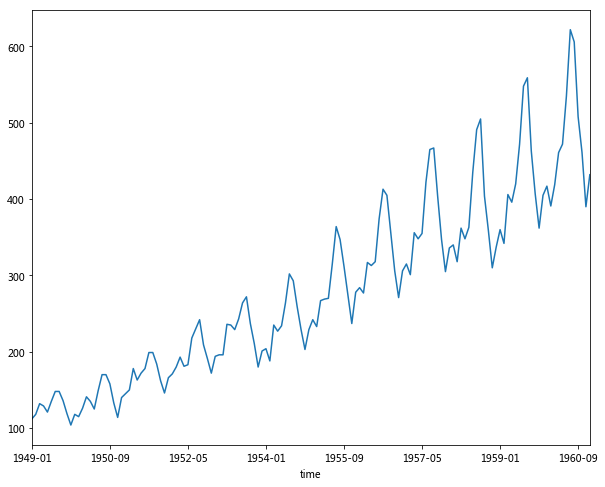

In [26]:
plt.figure(figsize=(10,8))
data = data.set_index('time')
data['passengers'].plot()
plt.show()

可以看出，我们的数据存在一定的周期性，这个周期性并不是一个重复出现某个值，而是趋势的增长过程有一定的规律性，这个我们人肉眼就能看得出来，但是实际上计算机要识别这种规律就有一定的难度了，这时候就需要使用我们的`LSTM`。
好的，数据已经预览完了，接下来我们得思考一下怎么预测，怎么把数据处理为 `LSTM` 网络需要的格式。


# 2.数据预处理

In [328]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.model_selection import train_test_split


def load_dataset(filename, test_size=0.2):
    scaler = MinMaxScaler()
    df = pd.read_csv(filename, sep=',', usecols=[1])
    data_all = np.array(df).astype('float')
    # 规一化data_all
    data_all = scaler.fit_transform(data_all)

    data = []
    time_steps = 10
    for i in range(len(data_all)-time_steps):
        data.append(data_all[i: i + time_steps])

    data_reshape = np.array(data).astype('float64')
    np.random.shuffle(data_reshape)

    x = np.array(data_reshape)
    y = data_reshape[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)
    
    return X_train, X_test, y_train, y_test, scaler


In [329]:
X_train, X_test, y_train, y_test, scaler = load_dataset('../data/international-airline-passengers.csv')

# print X_train
# print X_test
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape


(107, 10, 1)
(27, 10, 1)
(107, 1)
(27, 1)


# 3.创建LSTM网络模型

In [330]:
model = Sequential()
model.add(LSTM(100,input_shape=(None,1), return_sequences=True))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, None, 100)         40800     
_________________________________________________________________
lstm_103 (LSTM)              (None, 150)               150600    
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________


In [331]:
# train
model.fit(X_train, y_train, batch_size=512, validation_data=(X_test, y_test), epochs=100)

Train on 107 samples, validate on 27 samples
Epoch 1/100
107/107 [==============================] - 5s 50ms/step - loss: 0.1688 - acc: 0.0093 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 2/100
107/107 [==============================] - 0s 318us/step - loss: 0.0405 - acc: 0.0093 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 3/100
107/107 [==============================] - 0s 406us/step - loss: 0.0274 - acc: 0.0187 - val_loss: 0.0422 - val_acc: 0.0000e+00
Epoch 4/100
107/107 [==============================] - 0s 381us/step - loss: 0.0396 - acc: 0.0093 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 5/100
107/107 [==============================] - 0s 277us/step - loss: 0.0127 - acc: 0.0187 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 6/100
107/107 [==============================] - 0s 283us/step - loss: 0.0123 - acc: 0.0187 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 7/100
107/107 [==============================] - 0s 343us/step - loss: 0.0121 - acc: 0.0187 - val_loss: 0.0127 - val

Epoch 60/100
107/107 [==============================] - 0s 335us/step - loss: 0.0104 - acc: 0.0187 - val_loss: 0.0123 - val_acc: 0.0000e+00
Epoch 61/100
107/107 [==============================] - 0s 372us/step - loss: 0.0113 - acc: 0.0187 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 62/100
107/107 [==============================] - 0s 403us/step - loss: 0.0102 - acc: 0.0187 - val_loss: 0.0120 - val_acc: 0.0000e+00
Epoch 63/100
107/107 [==============================] - 0s 355us/step - loss: 0.0111 - acc: 0.0187 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 64/100
107/107 [==============================] - 0s 353us/step - loss: 0.0100 - acc: 0.0187 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 65/100
107/107 [==============================] - 0s 326us/step - loss: 0.0109 - acc: 0.0187 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 66/100
107/107 [==============================] - 0s 343us/step - loss: 0.0099 - acc: 0.0187 - val_loss: 0.0116 - val_acc: 0.0000e+00
Epoch 67/100
107/107

## 预测

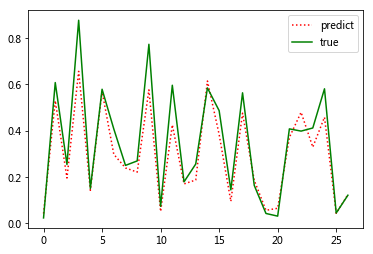

In [332]:
predict = model.predict(X_test)
fig = plt.figure(1)
plt.plot(predict, 'r:')
plt.plot(y_test, 'g-')
plt.legend(['predict', 'true'])
plt.show()

从上图来看，效果还是可以

## 测试

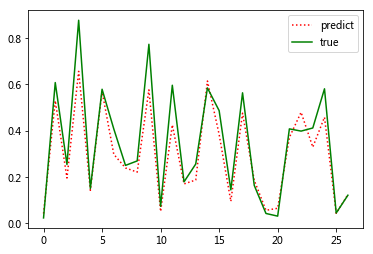

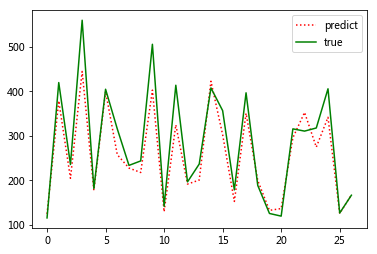

In [339]:
y_predict = model.predict(X_test)

fig = plt.figure(1)
plt.plot(y_predict, 'r:')
plt.plot(y_test, 'g-')
plt.legend(['predict', 'true'])

# 将y_predict and y_test 转换为真实的数据
y_predict = scaler.inverse_transform(y_predict).astype('int')
y_test_original = scaler.inverse_transform(y_test)
fig = plt.figure(2)
plt.plot(y_predict, 'r:')
plt.plot(y_test_original, 'g-')
plt.legend(['predict', 'true'])
plt.show()

以上预测出来的效果还是比较令人满意的！！！

# 附上完整的代码

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.model_selection import train_test_split
%matplotlib inline

def load_dataset(filename, test_size=0.2):
    scaler = MinMaxScaler()
    df = pd.read_csv(filename, sep=',', usecols=[1])
    data_all = np.array(df).astype('float')
    print data_all.shape
    # 规一化data_all
    data_all = scaler.fit_transform(data_all)

    data = []
    time_steps = 10
    for i in range(len(data_all)-time_steps):
        data.append(data_all[i: i + time_steps])

    data_reshape = np.array(data).astype('float64')
    np.random.shuffle(data_reshape)

    x = np.array(data_reshape)
    y = data_reshape[:,-1]

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=40)
    
    return X_train, X_test, y_train, y_test, scaler

def build_model():
    model = Sequential()
    # return_sequences is True, only return the last output sequence
    # False, return the full sequence
    model.add(LSTM(100, input_shape=(None,1), return_sequences=True))
    model.add(LSTM(150, return_sequences=False))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

def train_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

# run
X_train, X_test, y_train, y_test, scaler = load_dataset('../data/international-airline-passengers.csv')
model = build_model()
train_model(model, X_train, X_test, y_train, y_test)


y_predict = model.predict(X_test)
fig = plt.figure(1)
plt.plot(y_predict, 'r:')
plt.plot(y_test, 'g-')
plt.legend(['predict', 'true'])

y_predict_real = scaler.inverse_transform(y_predict)
y_test_real = scaler.inverse_transform(y_test)
fig = plt.figure(2)
plt.plot(y_predict_real, 'r:')
plt.plot(y_test_real, 'g-')
plt.legend(['predict', 'true'])

plt.show()

# 总结
- 了解了`LSTM`的网络构造结构及使用方法
- 从模型的Fit来看, `acc` and `val_acc`其实是非常低的，但最后`predict`时，却能得到一个比较满意的结果
- 还需要进一步的学习`LSTM` 和 `RNN`